# Confidence

This notebook is about *confidence intervals* and how to interpret them, as well as alternate kinds of intervals.

## Setup

Let's load some libraries:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples

Initialize a random number generator:

In [2]:
rng = np.random.default_rng(20221004)

## Data and Preparation

It uses the [CHI Papers data set](FetchCHIPapers.ipynb).  Let's load the data:

In [3]:
papers = pd.read_csv('../data/chi-papers.csv')
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13403 entries, 0 to 13402
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        13292 non-null  object 
 1   year      13370 non-null  float64
 2   title     13370 non-null  object 
 3   keywords  3504 non-null   object 
 4   abstract  12872 non-null  object 
dtypes: float64(1), object(4)
memory usage: 523.7+ KB


We're going to look at the **mean length** of paper titles, in a given year.  Let's compute the paper title length in words:

In [4]:
papers['title_words'] = papers['title'].str.count(r'\w+')

Let's look at this year by year:

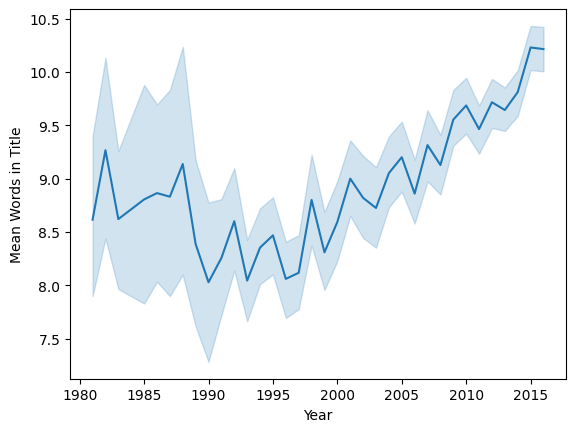

In [5]:
sns.lineplot(x='year', y='title_words', data=papers, estimator=np.mean)
plt.ylabel('Mean Words in Title')
plt.xlabel('Year')
plt.show()

For simple analysis, we are going to use a single year, 2010:

In [6]:
papers2010 = papers[papers['year'] == 2010]
papers2010['title_words'].describe()

count    653.000000
mean       9.686064
std        3.341651
min        2.000000
25%        7.000000
50%        9.000000
75%       12.000000
max       24.000000
Name: title_words, dtype: float64

In [7]:
tw2010 = papers2010['title_words']
n = tw2010.count()
n

653

## Confidence Interval

We can now compute a *confidence interval* for the mean number of words in the titles of CHI papers in 2010. We've seen how to do this with the standard error method:

$$
\bar{x} \pm 1.96 \frac{s}{\sqrt n}
$$

Let's compute a 95% confidence interval:

In [8]:
mean = tw2010.mean()
se = tw2010.sem()
ci_low = mean - 1.96 * se
ci_hi = mean + 1.96 * se
'{:.4} ({:.4}, {:.4})'.format(mean, ci_low, ci_hi)

'9.686 (9.43, 9.942)'

Now, what does this mean? One common interpretation is this: we are 95% confident that the true mean title length of papers is in the range (9.430, 9.942). This interpretation is supported by a number of sources, including the *Think Like a Data Scientist* textbook and [Penn State's STAT 200 material](https://online.stat.psu.edu/stat200/lesson/4/4.2/4.2.1).

But this interpretation is quite subtly incorrect, at least depending on how we interpret the word “confident”.  A very natural interpretation is something similar to “the true title length is probably in the range”, or “the probability the true title length is in the range is 95%”.

A confidence interval, however, is *not* a probabilistic statement about the true mean. Indeed, in frequentist statistics, probabilistic statements about population parameters are not possible, because they are fixed (but unknown).  A confidence interval is the result of a procedure that, 95% of the time, produces an interval containing the true mean.  [Deborah Mayo (1981)](https://www.jstor.org/stable/187185) writes this:

> It must be stressed, however, that having seen the value $x$, NP theory [classical confidence intervals] never permits one to conclude that the specific confidence interval formed covers the true value of $0$ with either $(1 - a)100\%$ probability or $(1 - a)100\%$ degree of confidence. Seidenfeld’s remark seems rooted in a (not uncommon) desire for NP confidence intervals to provide something which they cannot legitimately provide; namely, a measure of the degree of probability, belief, or support that an unknown parameter value lies in a specific interval. Following Savage (1962), the probability that a parameter lies in a specific interval may be referred to as a measure of final precision. While a measure of final precision may seem desirable, and while confidence levels are often (wrongly) interpreted as providing such a measure, no such interpretation is warranted. Admittedly, such a misinterpretation is encouraged by the word “confidence”.

[Tan and Tan (2010)](https://journals.sagepub.com/doi/pdf/10.1177/201010581001900316) provide a short summary of confidence interval interpretations.

While both the textbook and other reliable sources promote the “95% confident” interpretation, it is a decision with which I disagree, as it covers over subtle differences in how intervals are actually computed and what the confidence interval is.

## Credible Interval

If we want an interval that *does* mean there is a 95% probability the population mean is in the interval, we need to turn to Bayesian statistics.  The heart of Bayesian statistics is to apply Bayes' theorem to update knowledge.  If $y$ is our observed data, and $\theta$ is our knowledge, we have:

$$
\P[\theta | y] = \frac{\P[y | \theta] \P[\theta]}{\P[y]}
$$

In the case of inferring the mean number of words in a title, $\theta$ is the true (population) mean title length, and $y$ is the observed title length (actually all the individual observed lengths, not just the mean).  Bayes' theorm then decomposes into a few pieces:

- $\P[\theta]$ is the *prior*: our knowledge or assumptions about the title length before we obtain data.
- $\P[y | \theta]$ is the *likelihood model*: for a given true title mean length $\theta$, how likely is it that we would observe a particular collection of observed title lengths?
- $\P[\theta | y]$ is the *posterior distribution*: given our prior knowledge, and the data we observed, how likely is a particular value (or region of values, for a continuous parameter) of the parameter $\theta$?
- $\P[y]$ is the data probability; it can be derived with $\P[y] = \int \P[y|\theta] \P[\theta] d\theta$.  For a given experiment, however, $y$ is fixed, and so $\P[y]$ can be treated as a constant.

That means, in order to do inference, we need to define a couple of things — the prior distribution and the likelihood model.

The observed data takes the form of counts: the number of words in an article title.  Counts often (but not always) follow either a [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution) or a negative binomial distribution.  We will model the number of words in the title as a Poisson with rate $\lambda$; the mean of Poisson-distributed data is also $\lambda$, so our problem becomes: infer the Poisson rate for the data.

We next need a prior distribution.  The idea is that it should represent our state of knowledge before the experiment; if we don't know a whole lot, a high-variance distribution over a range of plausible values can be a pretty good choice.  For mathematical convenience, we are going to use a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) for our prior (in a more advanced analysis, we might use a normal, but that requires more advanced computational machinery than I want to introduce right now).

Let's start with $\mathrm{Gamma}(3, 3)$, which is pretty broad over a range of values from 0 to 30:

Text(0.5, 1.0, 'Prior Distribution')

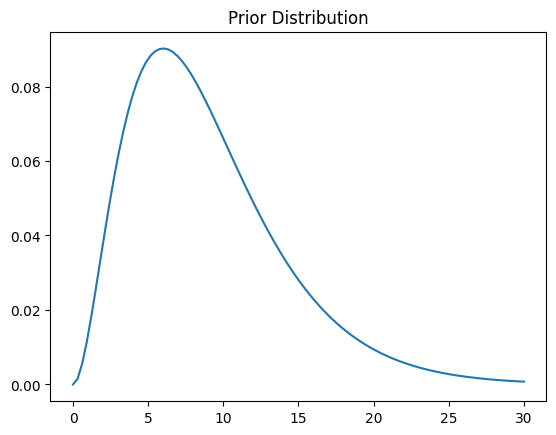

In [9]:
prior_shape = 3
prior_scale = 3
prior = stats.gamma(prior_shape, scale=prior_scale)
thetas = np.linspace(0, 30, 100)
plt.plot(thetas, prior.pdf(thetas))
plt.title('Prior Distribution')

Now, the Gamma distribution is what is called a *conjugate prior* for the Poisson.  That means that if the prior $\P[\lambda]$ is Gamma-distributed, the posterior $\P[\lambda | y]$ is also Gamma-distributed, and we can derive it as follows:

$$\begin{align*}
\P[\lambda] & = \mathrm{Gamma}(\kappa, \beta) \\
\P[\lambda | y] & = \mathrm{Gamma}(\kappa + \sum y_i, \beta + n)
\end{align*}$$

The `gamma` class takes a scale parameter that is inverted from our $\beta$.  So we can derive the posterior distribution as follows:

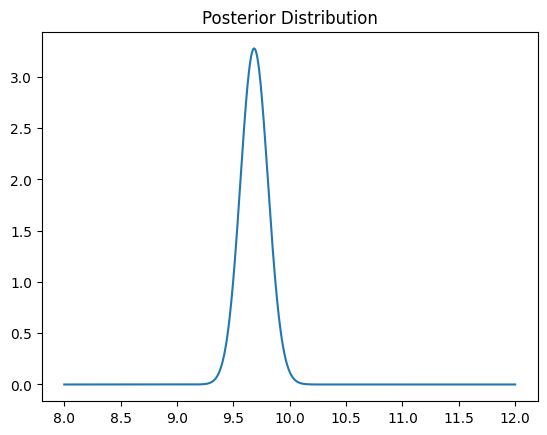

In [10]:
post_shape = prior_shape + tw2010.sum()
post_scale = 1 / (1 / prior_scale + n)
post = stats.gamma(post_shape, scale=post_scale)
thetas = np.linspace(8, 12, 1000)
plt.plot(thetas, post.pdf(thetas))
plt.title('Posterior Distribution')
plt.show()

With this posterior distribution, the **95% credible interval** is given by the central 95% of the posterior probability mass:

In [11]:
post.ppf([0.025, 0.975])

array([9.44852551, 9.92580248])

This is similar to the 95% confidence interval, but it isn't quite the same.  This interval, however, **does** mean that $\P[9.4485 \le \mu \le 9.9258] = 0.95$, so we can make statements of the form “we are 95% confident the true mean...” without running into problems.

Now, we have made a number of assumptions here, both about our prior knowledge and about the “data generating process” (the likelihood model - how we get observations of title lengths). It would be good to check if this is actually realistic.

One way to do this is through a *positive predictive check*.  Our model is generative: it describes a probabilistic process by which observed data comes into existence. If we use this model to generate some *new* data, does the new data look like the observe data?  If it does, then this is evidence that our model is accurately modeling the data, at least with respect to our observations and parameters of interest.

The goal is to draw a new sample (of size $n$, for comparability purposes).  The easy way to do this is to do the following $n$ times:

1. Draw a mean $\lambda^* \sim \P[\lambda | y]$
2. Draw an observation $y^* \sim \P[y | \lambda^*]$

So let's draw some $\lambda^*$ values:

In [12]:
ppc_means = post.rvs(n)

And new “observations”:

In [13]:
ppc_obs = rng.poisson(ppc_means)

Now that we have some simulated observations, we want to compare these to the actual observations.  Let's plot their distributions together:

Text(0.5, 1.0, 'Posterior Predictive Check')

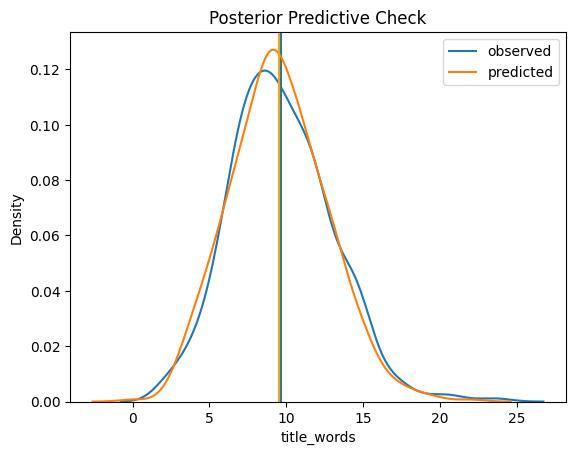

In [14]:
sns.kdeplot(tw2010, label='observed')
plt.axvline(tw2010.mean())
sns.kdeplot(ppc_obs, label='predicted')
plt.axvline(ppc_obs.mean(), color='orange')
plt.legend()
plt.title('Posterior Predictive Check')

Interpreting these is a bit of an art, but that's not a bad fit.  What this means is that the model we encoded does a reasonable good job of modeling the observed data, so we can have more faith in our inferences.  We can also look at a Q-Q plot:

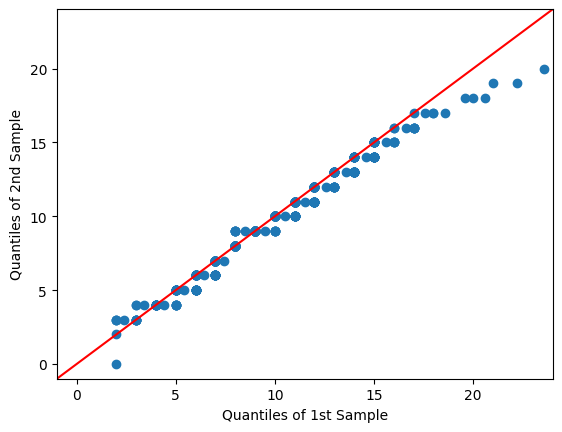

In [15]:
qqplot_2samples(tw2010, ppc_obs, line='45')
plt.show()

It tails off on the top, but is pretty good through the middle. We can probably create a better-fitting model with more work, but this will suffice to demonstrate the principle.